In [5]:
import cv2
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
y_dim=1020//2
x_dim=678//2

In [166]:


png_files = [file for file in os.listdir('Data/labels') if file.endswith('.png')]

for file in png_files:
    image=cv2.imread(os.path.join('Data/labels',file))
    resized_image = cv2.resize(image, (y_dim,x_dim))
    cv2.imwrite(os.path.join('Data/train/inputs',file),resized_image)

In [167]:

# Set the paths for the 'train' and 'test' folders
train_folder = 'Data/train/inputs'  # Replace 'path_to_train_folder' with the actual path to your 'train' folder
test_folder = 'Data/test/inputs'    # Replace 'path_to_test_folder' with the actual path to your 'test' folder

# Get a list of all image files in the 'train' folder
image_files = [file for file in os.listdir(train_folder) if file.endswith('.png')]
# Calculate the number of images to transfer to the 'test' folder (10% of the total images)
num_images_test = int(len(image_files) * 0.1)

# Randomly select images to transfer to the 'test' folder
images_to_move = random.sample(image_files, num_images_test)

# Move the selected images to the 'test' folder
for img_file in images_to_move:
    src_path = os.path.join(train_folder, img_file)
    dst_path = os.path.join(test_folder, img_file)
    shutil.move(src_path, dst_path)

print(f"{num_images_test} images transferred from 'train' to 'test' folder.")

80 images transferred from 'train' to 'test' folder.


In [168]:
train_inputs=[]
train_targets=[]
for file in os.listdir('Data/train/inputs'):
    image=cv2.imread(os.path.join('Data/train/inputs', file))
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    train_inputs.append(image)
    train_targets.append(upscaled_img)
train_inputs=np.array(train_inputs)
train_targets=np.array(train_targets)
    
    

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os

# Define the SRCNN model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define training parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 20


In [170]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
train_inputs=[]
train_targets=[]
for file in os.listdir('Data/train/inputs'):
    image=cv2.imread(os.path.join('Data/train/inputs', file))
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    train_inputs.append(upscaled_img)
    train_targets.append(image)
train_inputs=np.array(train_inputs)
train_targets=np.array(train_targets)
    
    
# Assuming train_inputs and train_targets are your data arrays
train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()

# Create a TensorDataset from inputs and targets
train_dataset = TensorDataset(train_inputs, train_targets)

# Create a DataLoader with batch size
batch_size = 16  # Adjust batch size based on your memory constraints
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, criterion, and optimizer
model = SRCNN()  # Assuming SRCNN is your model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches=0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 3, 1, 2))  # Permute channels to [batch_size, channels, height, width]
        loss = criterion(outputs, targets.permute(0, 3, 1, 2))
        loss.backward()
        optimizer.step()
        num_batches+=1
        running_loss += loss.item()
    print(num_batches)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/num_batches:.4f}')

45
Epoch 1/20, Loss: 1617.0325
45
Epoch 2/20, Loss: 554.5489
45
Epoch 3/20, Loss: 425.3337
45
Epoch 4/20, Loss: 392.6773
45
Epoch 5/20, Loss: 363.8784
45
Epoch 6/20, Loss: 357.7389
45
Epoch 7/20, Loss: 353.4109
45
Epoch 8/20, Loss: 327.7510
45
Epoch 9/20, Loss: 333.6566
45
Epoch 10/20, Loss: 316.8654
45
Epoch 11/20, Loss: 311.9307
45
Epoch 12/20, Loss: 307.0494
45
Epoch 13/20, Loss: 304.4346
45
Epoch 14/20, Loss: 306.2814
45
Epoch 15/20, Loss: 310.5803
45
Epoch 16/20, Loss: 300.0855
45
Epoch 17/20, Loss: 316.6915
45
Epoch 18/20, Loss: 308.3305
45
Epoch 19/20, Loss: 302.6983
45
Epoch 20/20, Loss: 295.2379


In [171]:
torch.save(model.state_dict(), 'model_by2.pth')

In [172]:
test_inputs=[]
test_targets=[]
for file in os.listdir('Data/test/inputs'):
    image=cv2.imread(os.path.join('Data/test/inputs', file))
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    test_inputs.append(upscaled_img)
    test_targets.append(image)
test_inputs=np.array(test_inputs)
test_targets=np.array(test_targets)
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets
                               ).float()
test_dataset = TensorDataset(test_inputs, test_targets)

# Create a DataLoader with batch size
batch_size = 16  # Adjust batch size based on your memory constraints
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [173]:
running_loss = 0.0
num_batches=0
for inputs, targets in test_dataloader:
    optimizer.zero_grad()
    outputs = model(inputs.permute(0, 3, 1, 2))  # Permute channels to [batch_size, channels, height, width]
    targets = targets.float()
    loss = criterion(outputs, targets.permute(0, 3, 1, 2))
    num_batches+=1
    running_loss += loss.item()
print(num_batches)
    

print(running_loss/num_batches)

5
320.03388671875


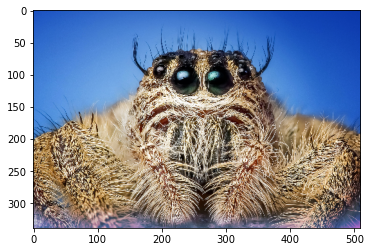

In [174]:
test_image=cv2.imread('Data/test/inputs/0189.png')
test_image=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

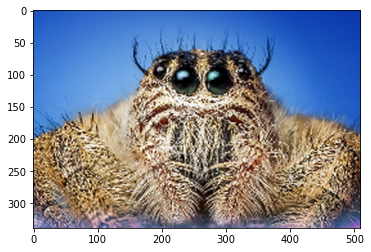

In [175]:

downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
plt.imshow(upscaled_img)

In [176]:
test_image_tensor=torch.from_numpy(upscaled_img).float().unsqueeze(0)

In [177]:
test_image_tensor.shape

torch.Size([1, 339, 510, 3])

In [178]:
test_output_tensor = model(test_image_tensor.permute(0, 3, 1, 2))

In [179]:
output_array = test_output_tensor.detach().squeeze().permute(1, 2, 0).cpu().numpy()

In [180]:
output_array=output_array.astype('uint8')

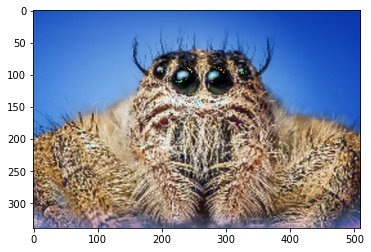

In [181]:
plt.imshow(output_array)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import cv2
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

y_dim=1020//2
x_dim=678//2


batch_size = 16
learning_rate = 0.001
num_epochs = 20   

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


batch_size = 16
learning_rate = 0.001
num_epochs = 20

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
train_inputs=[]
train_targets=[]
for file in os.listdir('Data/train/inputs'):
    image=cv2.imread(os.path.join('Data/train/inputs', file))
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    train_inputs.append(y_upscaled_img)
    train_targets.append(y_image)
train_inputs=np.array(train_inputs)
train_targets=np.array(train_targets)
train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()

train_dataset = TensorDataset(train_inputs, train_targets)


batch_size = 16 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = SRCNN()  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches=0
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        num_batches+=1
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/num_batches:.4f}')

45
Epoch 1/20, Loss: 2408.5367
45
Epoch 2/20, Loss: 458.5236
45
Epoch 3/20, Loss: 345.6365
45
Epoch 4/20, Loss: 307.3706
45
Epoch 5/20, Loss: 294.5379
45
Epoch 6/20, Loss: 285.2554
45
Epoch 7/20, Loss: 281.4729
45
Epoch 8/20, Loss: 277.6116
45
Epoch 9/20, Loss: 274.7038
45
Epoch 10/20, Loss: 273.9032
45
Epoch 11/20, Loss: 273.0682
45
Epoch 12/20, Loss: 276.2297
45
Epoch 13/20, Loss: 270.3017
45
Epoch 14/20, Loss: 269.6119
45
Epoch 15/20, Loss: 268.6062
45
Epoch 16/20, Loss: 277.2893
45
Epoch 17/20, Loss: 269.8624
45
Epoch 18/20, Loss: 266.7956
45
Epoch 19/20, Loss: 266.2616
45
Epoch 20/20, Loss: 265.6980


In [7]:
torch.save(model.state_dict(), 'model_y.pth')

In [10]:
test_inputs=[]
test_targets=[]
for file in os.listdir('Data/test/inputs'):
    image=cv2.imread(os.path.join('Data/test/inputs', file))
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    test_inputs.append(y_upscaled_img)
    test_targets.append(y_image)
test_inputs=np.array(test_inputs)
test_targets=np.array(test_targets)
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets
                               ).float()
test_dataset = TensorDataset(test_inputs, test_targets)


batch_size = 16  
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
running_loss = 0.0
num_batches=0
for inputs, targets in test_dataloader:
    optimizer.zero_grad()
    outputs = model(inputs.unsqueeze(1)) 
    targets = targets.float()
    loss = criterion(outputs, targets.unsqueeze(1))
    num_batches+=1
    running_loss += loss.item()
    

print(running_loss/num_batches)

5
295.4942626953125


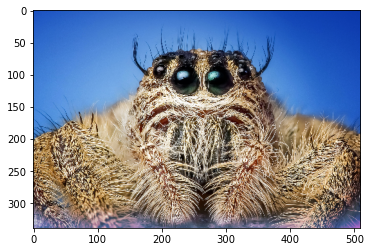

In [12]:
test_image=cv2.imread('Data/test/inputs/0189.png')
test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image_BGR)

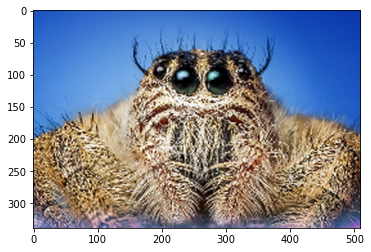

In [13]:
downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
upscaled_img_BGR=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2RGB)
plt.imshow(upscaled_img_BGR)

In [36]:
upscaled_img_YCbCr=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
Y,Cb,Cr=cv2.split(upscaled_img_YCbCr)
test_image_tensor=torch.from_numpy(Y).float().unsqueeze(0)
test_output_tensor = model(test_image_tensor.unsqueeze(0))
output_array = test_output_tensor.detach().squeeze().cpu().numpy()
output_array=output_array.astype('uint8')
Cb_resized = cv2.resize(Cb, (510, 339))
Cr_resized = cv2.resize(Cr, (510, 339))
enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])
enhanced_image_rgb = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)
plt.imshow(enhanced_image_rgb)

torch.Size([1, 339, 510])

In [31]:
psnr_sum_bilinear=0
psnr_sum_srcnn=0
counter=0
for file in os.listdir('Data/test/inputs/'):
    test_image=cv2.imread(os.path.join('Data/test/inputs', file))
    test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    upscaled_img_BGR=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2RGB)
    upscaled_img_YCbCr=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
    Y,Cb,Cr=cv2.split(upscaled_img_YCbCr)
    test_image_tensor=torch.from_numpy(Y).float().unsqueeze(0)
    test_output_tensor = src_model(test_image_tensor.unsqueeze(0))
    output_array = test_output_tensor.detach().squeeze().cpu().numpy()
    output_array=output_array.astype('uint8')
    Cb_resized = cv2.resize(Cb, (510, 339))
    Cr_resized = cv2.resize(Cr, (510, 339))
    enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])
    enhanced_image_rgb = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)
    psnr_sum_srcnn+= psnr(test_image_BGR, enhanced_image_rgb)
    psnr_sum_bilinear+=psnr(test_image_BGR, upscaled_img_BGR)
    counter+=1
print('bilinear',psnr_sum_bilinear/counter)
print('Vanilla SRCNN',psnr_sum_srcnn/counter)

bilinear 22.868965888023375
Vanilla SRCNN 22.543754410743713


In [42]:
Cb_resized = cv2.resize(Cb, (510, 339))
Cr_resized = cv2.resize(Cr, (510, 339))

In [43]:
enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])

In [44]:
enhanced_image_rgb = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
train_inputs=[]
train_targets=[]
for file in os.listdir('Data/train/inputs'):
    image=cv2.imread(os.path.join('Data/train/inputs', file))
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    train_inputs.append(y_upscaled_img)
    train_targets.append(y_image)
train_inputs=np.array(train_inputs)
train_targets=np.array(train_targets)

train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()


train_dataset = TensorDataset(train_inputs, train_targets)


batch_size = 16 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = SRCNNWithAttention()  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches=0
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        num_batches+=1
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/num_batches:.4f}')

Epoch 1/20, Loss: 16883.7421
Epoch 2/20, Loss: 16322.9256
Epoch 3/20, Loss: 15139.0758
Epoch 4/20, Loss: 13391.9554
Epoch 5/20, Loss: 11315.6229
Epoch 6/20, Loss: 9171.9227
Epoch 7/20, Loss: 7167.3350
Epoch 8/20, Loss: 5332.0878
Epoch 9/20, Loss: 3856.2401
Epoch 10/20, Loss: 1951.9091
Epoch 11/20, Loss: 367.0933
Epoch 12/20, Loss: 304.7237
Epoch 13/20, Loss: 290.6553
Epoch 14/20, Loss: 284.2915
Epoch 15/20, Loss: 280.0557
Epoch 16/20, Loss: 277.3765
Epoch 17/20, Loss: 275.5073
Epoch 18/20, Loss: 273.8480
Epoch 19/20, Loss: 275.3220
Epoch 20/20, Loss: 280.8429


In [50]:
torch.save(model.state_dict(), 'model_att.pth')

In [51]:
test_inputs=[]
test_targets=[]
for file in os.listdir('Data/test/inputs'):
    image=cv2.imread(os.path.join('Data/test/inputs', file))
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    test_inputs.append(y_upscaled_img)
    test_targets.append(y_image)
test_inputs=np.array(test_inputs)
test_targets=np.array(test_targets)
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets
                               ).float()
test_dataset = TensorDataset(test_inputs, test_targets)


batch_size = 16  
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [52]:
running_loss = 0.0
num_batches=0
for inputs, targets in test_dataloader:
    optimizer.zero_grad()
    outputs = model(inputs.unsqueeze(1)) 
    targets = targets.float()
    loss = criterion(outputs, targets.unsqueeze(1))
    num_batches+=1
    running_loss += loss.item()
    

print(running_loss/num_batches)

305.21961975097656


True

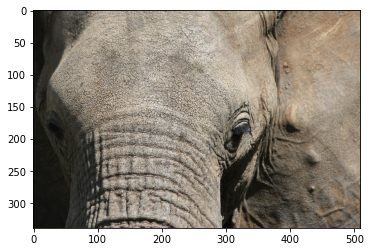

In [185]:
test_image=cv2.imread('Data/train/inputs/0729.png')
test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image_BGR)
test_image_RGB=cv2.cvtColor(test_image_BGR,cv2.COLOR_BGR2RGB)
cv2.imwrite('elephant_highres.jpg',test_image_RGB)

True

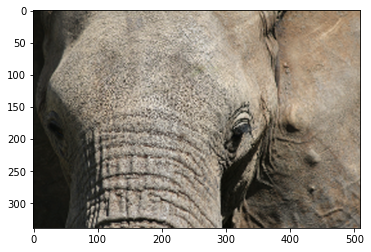

In [186]:
downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
upscaled_img_BGR=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2RGB)
plt.imshow(upscaled_img_BGR)
upscaled_img_RGB=cv2.cvtColor(upscaled_img_BGR,cv2.COLOR_BGR2RGB)
cv2.imwrite('elephant_bilinear.jpg',upscaled_img_RGB)

True

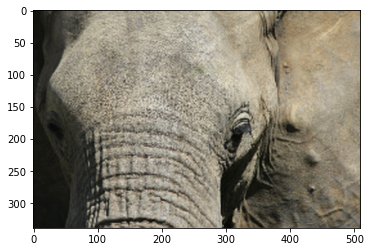

In [187]:
upscaled_img_YCbCr=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
Y,Cb,Cr=cv2.split(upscaled_img_YCbCr)
test_image_tensor=torch.from_numpy(Y).float().unsqueeze(0)
test_output_tensor = model(test_image_tensor.unsqueeze(0))
output_array = test_output_tensor.detach().squeeze().cpu().numpy()
output_array=output_array.astype('uint8')
Cb_resized = cv2.resize(Cb, (510, 339))
Cr_resized = cv2.resize(Cr, (510, 339))
enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])
enhanced_image_rgb = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)
plt.imshow(enhanced_image_rgb)
enhanced_image_bgr=cv2.cvtColor(enhanced_image_rgb,cv2.COLOR_BGR2RGB)
cv2.imwrite('elephant_attention_SRCNN.jpg',enhanced_image_bgr)

In [188]:
import torch
import torch.nn.functional as F

def psnr(img1, img2):
 
    img1_tensor = torch.tensor(img1, dtype=torch.float32)
    img2_tensor = torch.tensor(img2, dtype=torch.float32)

   
    mse = F.mse_loss(img1_tensor, img2_tensor)

    
    max_pixel = 255.0 
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))

    return psnr_value.item()  


psnr_value = psnr(test_image_BGR, upscaled_img_BGR)
print(f'PSNR: {psnr_value:.2f} dB')

PSNR: 22.37 dB


In [189]:
psnr_value = psnr(test_image_BGR, enhanced_image_rgb)
print(f'PSNR: {psnr_value:.2f} dB')

PSNR: 22.49 dB


In [175]:

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
src_model=SRCNN()
src_model.load_state_dict(torch.load('model_y.pth'))

<All keys matched successfully>

True

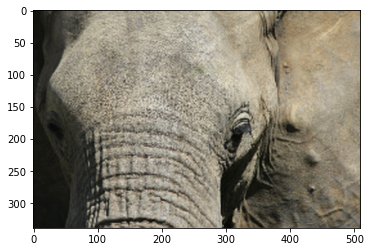

In [190]:
upscaled_img_YCbCr=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
Y,Cb,Cr=cv2.split(upscaled_img_YCbCr)
test_image_tensor=torch.from_numpy(Y).float().unsqueeze(0)
test_output_tensor = src_model(test_image_tensor.unsqueeze(0))
output_array = test_output_tensor.detach().squeeze().cpu().numpy()
output_array=output_array.astype('uint8')
Cb_resized = cv2.resize(Cb, (510, 339))
Cr_resized = cv2.resize(Cr, (510, 339))
enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])
enhanced_image_rgb_srcnn = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)
plt.imshow(enhanced_image_rgb)
enhanced_image_bgr_srcnn=cv2.cvtColor(enhanced_image_rgb_srcnn,cv2.COLOR_BGR2RGB)
cv2.imwrite('elephant_SRCNN.jpg',enhanced_image_bgr_srcnn)

In [191]:
psnr_value = psnr(test_image_BGR, enhanced_image_rgb)
print(f'PSNR: {psnr_value:.2f} dB')

PSNR: 22.49 dB


Attention model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import cv2
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

y_dim=1020//2
x_dim=678//2


batch_size = 16
learning_rate = 0.001
num_epochs = 20 

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        attention_weights = self.sigmoid(self.conv2(out))  
        out = x * attention_weights  
        return out

class SRCNNwithAttention(nn.Module):
    def __init__(self, channels=1):
        super(SRCNNwithAttention, self).__init__()
        self.attention_block = AttentionBlock(channels, 64)
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2) 
       

    def forward(self, x):
        x = self.attention_block(x) 
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out=self.conv3(out)
       
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2
train_inputs=[]
train_targets=[]
for file in os.listdir('Data/train/inputs'):
    image=cv2.imread(os.path.join('Data/train/inputs', file))
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    train_inputs.append(y_upscaled_img)
    train_targets.append(y_image)
train_inputs=np.array(train_inputs)
train_targets=np.array(train_targets)

train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()


train_dataset = TensorDataset(train_inputs, train_targets)


batch_size = 16  
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = SRCNNwithAttention()  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches=0
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        num_batches+=1
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/num_batches:.4f}')

Epoch 1/20, Loss: 4769.8515
Epoch 2/20, Loss: 648.8136
Epoch 3/20, Loss: 414.7429
Epoch 4/20, Loss: 342.2804
Epoch 5/20, Loss: 316.3245
Epoch 6/20, Loss: 301.7852
Epoch 7/20, Loss: 292.3440
Epoch 8/20, Loss: 287.3642
Epoch 9/20, Loss: 284.4219
Epoch 10/20, Loss: 282.2839
Epoch 11/20, Loss: 280.6054
Epoch 12/20, Loss: 279.5654
Epoch 13/20, Loss: 278.2803
Epoch 14/20, Loss: 277.3909
Epoch 15/20, Loss: 276.5349
Epoch 16/20, Loss: 275.5681
Epoch 17/20, Loss: 275.1839
Epoch 18/20, Loss: 274.0939
Epoch 19/20, Loss: 274.2115
Epoch 20/20, Loss: 273.7483


In [17]:
torch.save(model.state_dict(), 'model_att.pth')

In [18]:
test_inputs=[]
test_targets=[]
for file in os.listdir('Data/test/inputs'):
    image=cv2.imread(os.path.join('Data/test/inputs', file))
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    test_inputs.append(y_upscaled_img)
    test_targets.append(y_image)
test_inputs=np.array(test_inputs)
test_targets=np.array(test_targets)
test_inputs = torch.from_numpy(test_inputs).float()
test_targets = torch.from_numpy(test_targets
                               ).float()
test_dataset = TensorDataset(test_inputs, test_targets)


batch_size = 16 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [19]:
running_loss = 0.0
num_batches=0
for inputs, targets in test_dataloader:
    optimizer.zero_grad()
    outputs = model(inputs.unsqueeze(1))  
    targets = targets.float()
    loss = criterion(outputs, targets.unsqueeze(1))
    num_batches+=1
    running_loss += loss.item()
    

print(running_loss/num_batches)

303.9714416503906


True

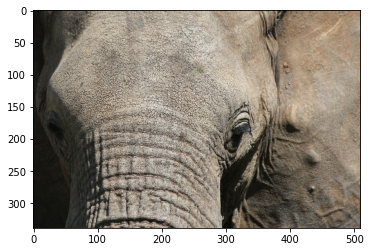

In [20]:
test_image=cv2.imread('Data/train/inputs/0729.png')
test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image_BGR)
test_image_RGB=cv2.cvtColor(test_image_BGR,cv2.COLOR_BGR2RGB)
cv2.imwrite('elephant_highres.jpg',test_image_RGB)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        attention_weights = self.sigmoid(self.conv2(out)) 
        out = x * attention_weights 
        return out

class DeeperSRCNNwithAttention(nn.Module):
    def __init__(self, channels=1):
        super(DeeperSRCNNwithAttention, self).__init__()
        self.attention_block = AttentionBlock(channels, 64)
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1) 
       

    def forward(self, x):
        x = self.attention_block(x) 
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.conv5(out)  
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperSRCNNwithAttention().to(device)

Output image shape: torch.Size([1, 1, 64, 64])


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2
train_inputs=[]
train_targets=[]
for file in os.listdir('Data/train/inputs'):
    image=cv2.imread(os.path.join('Data/train/inputs', file))
    y_image=cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    downscaled_img=cv2.resize(image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    y_upscaled_img=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    train_inputs.append(y_upscaled_img)
    train_targets.append(y_image)
train_inputs=np.array(train_inputs)
train_targets=np.array(train_targets)

train_inputs = torch.from_numpy(train_inputs).float()
train_targets = torch.from_numpy(train_targets).float()


train_dataset = TensorDataset(train_inputs, train_targets)


batch_size = 16 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




deep_model = DeeperSRCNNwithAttention()  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches=0
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = deep_model(inputs)  
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        num_batches+=1
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/num_batches:.4f}')

Epoch 1/20, Loss: 2035.3388
Epoch 2/20, Loss: 406.2940
Epoch 3/20, Loss: 324.2899
Epoch 4/20, Loss: 294.4426
Epoch 5/20, Loss: 281.8443
Epoch 6/20, Loss: 271.9578
Epoch 7/20, Loss: 268.6031
Epoch 8/20, Loss: 274.5396
Epoch 9/20, Loss: 267.6777
Epoch 10/20, Loss: 263.4843
Epoch 11/20, Loss: 261.7744
Epoch 12/20, Loss: 260.5167
Epoch 13/20, Loss: 260.3689
Epoch 14/20, Loss: 259.3476
Epoch 15/20, Loss: 259.1253
Epoch 16/20, Loss: 257.4999
Epoch 17/20, Loss: 256.1212
Epoch 18/20, Loss: 255.1211
Epoch 19/20, Loss: 279.5503
Epoch 20/20, Loss: 278.7414


In [4]:
torch.save(deep_model.state_dict(), 'model_deep_att.pth')

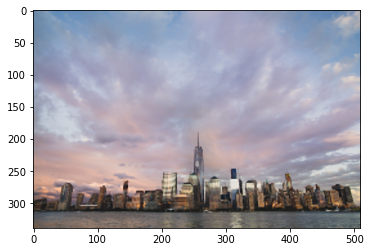

In [9]:
test_image=cv2.imread('Data/train/inputs/0057.png')
downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
upscaled_img_YCbCr=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
Y,Cb,Cr=cv2.split(upscaled_img_YCbCr)
test_image_tensor=torch.from_numpy(Y).float().unsqueeze(0)
test_output_tensor = deep_model(test_image_tensor.unsqueeze(0))
output_array = test_output_tensor.detach().squeeze().cpu().numpy()
output_array=output_array.astype('uint8')
Cb_resized = cv2.resize(Cb, (510, 339))
Cr_resized = cv2.resize(Cr, (510, 339))
enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])
enhanced_image_rgb_srcnn = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)
plt.imshow(enhanced_image_rgb_srcnn)

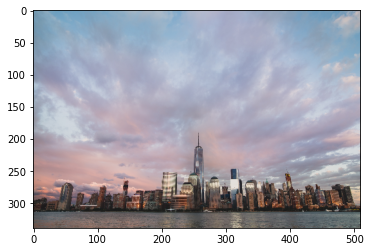

In [14]:
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

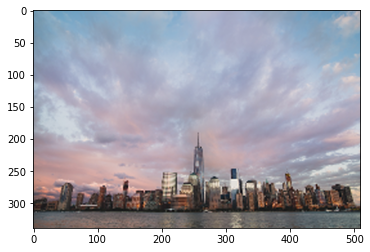

In [15]:
plt.imshow(cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2RGB))

In [8]:
def psnr(img1, img2):
 
    img1_tensor = torch.tensor(img1, dtype=torch.float32)
    img2_tensor = torch.tensor(img2, dtype=torch.float32)

   
    mse = F.mse_loss(img1_tensor, img2_tensor)

   
    max_pixel = 255.0  
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))

    return psnr_value.item() 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
src_model=SRCNN()
src_model.load_state_dict(torch.load('model_y.pth'))


<All keys matched successfully>

In [11]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        attention_weights = self.sigmoid(self.conv2(out)) 
        out = x * attention_weights  
        return out

class DeeperSRCNNwithAttention(nn.Module):
    def __init__(self, channels=1):
        super(DeeperSRCNNwithAttention, self).__init__()
        self.attention_block = AttentionBlock(channels, 64)
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1) 
      

    def forward(self, x):
        x = self.attention_block(x)  
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.conv5(out) 
        
        return out


In [12]:
deep_model = DeeperSRCNNwithAttention()
deep_model.load_state_dict(torch.load('model_deep_att.pth'))

<All keys matched successfully>

In [15]:

psnr_sum_bilinear=0
psnr_sum_deepattsrcnn=0
counter=0
for file in os.listdir('Data/test/inputs/'):
    test_image=cv2.imread(os.path.join('Data/test/inputs', file))
    test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
    upscaled_img=cv2.resize(downscaled_img,(y_dim,x_dim),interpolation=cv2.INTER_CUBIC)
    upscaled_img_BGR=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2RGB)
    upscaled_img_YCbCr=cv2.cvtColor(upscaled_img, cv2.COLOR_BGR2YCrCb)
    Y,Cb,Cr=cv2.split(upscaled_img_YCbCr)
    test_image_tensor=torch.from_numpy(Y).float().unsqueeze(0)
    test_output_tensor = deep_model(test_image_tensor.unsqueeze(0))
    output_array = test_output_tensor.detach().squeeze().cpu().numpy()
    output_array=output_array.astype('uint8')
    Cb_resized = cv2.resize(Cb, (510, 339))
    Cr_resized = cv2.resize(Cr, (510, 339))
    enhanced_image_ycbcr = cv2.merge([output_array,  Cr_resized,Cb_resized,])
    enhanced_image_rgb = cv2.cvtColor(enhanced_image_ycbcr, cv2.COLOR_YCrCb2BGR)
    psnr_sum_deepattsrcnn+= psnr(test_image_BGR, enhanced_image_rgb)
    psnr_sum_bilinear+=psnr(test_image_BGR, upscaled_img_BGR)
    counter+=1
print('bilinear',psnr_sum_bilinear/counter)
print('Deep SRCNN with attention',psnr_sum_deepattsrcnn/counter)

bilinear 22.868965888023375
Deep SRCNN with attention 23.016958260536192


bilinear 22.868965888023375
Vanilla SRCNN 22.543754410743713


In [17]:
deep_model.eval()

DeeperSRCNNwithAttention(
  (attention_block): AttentionBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sigmoid): Sigmoid()
  )
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [20]:
test_image=cv2.imread('elephant_highres.jpg')
test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
downscaled_img=cv2.resize(test_image,(y_dim//2,x_dim//2),interpolation=cv2.INTER_CUBIC)
cv2.imwrite('downsample_elephant.jpg',downscaled_img)

True

In [25]:
esrgan_image=cv2.imread('elephant_esrgan.png')
esrgan_image_BGR=cv2.cvtColor(esrgan_image, cv2.COLOR_BGR2RGB)
test_image_BGR.shape

(339, 510, 3)

In [26]:
psnr(cv2.resize(test_image_BGR, (510, 338)), esrgan_image_BGR)

22.15195655822754

In [27]:
test_image=cv2.imread('hamster_highres.jpg')
test_image_BGR=cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

True

In [28]:
esrgan_image=cv2.imread('hamster_esrgan.png')
esrgan_image_BGR=cv2.cvtColor(esrgan_image, cv2.COLOR_BGR2RGB)

In [29]:
psnr(cv2.resize(test_image_BGR, (510, 338)), esrgan_image_BGR)

21.543277740478516

In [30]:
(22.15195655822754+21.543277740478516)/2

21.847617149353027